# Introduction to pyshtools

*pyshtools* is a Python package for working with spherical harmonics. The routines of this package can be used to perform spherical harmonic transforms and reconstructions, rotations of data expressed in spherical harmonics, multitaper spectral analyses on the sphere, and the creation of publication quality graphics. The base functions are fast routines written in Fortran 95 from the SHTOOLS package, and *pyshtools* provides easy access to these by use of Python-wrapper functions and a compact class interface.

To get started, import the standard *matplotlib* library for graphics, *numpy* for mathematical extensions to Python, and *pyshtools*:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyshtools as pysh

The *pyshtools* package contains several classes, including `SHCoeffs`, `SHGrid`, and `SHWindow`, a subpackage `shtools` that contains the Python-wrapped Fortran functions, and several subpackages that contain both native python routines and references to routines in `shtools` (`constant`,  `legendre`, `expand`, `shio`, `spectralanalysis`, `rotate`, `gravmag`, and `util`). The classes `SHCoeffs`, `SHGrid`, and `SHWindow` bundle the vast majority of *pyshtools* functionality, and in this notebook we will demonstrate how to use the classes related to grids and spherical harmonic coefficients.

*pyshtools* can also define *matplotlib* configuration variables for creating publication quality graphics. These can be set using the function `figstyle` and by specifing the relative width of the image with respect to a journal page. If necessary, one can also specify optional parameters for the resolution of the screen, the maximum width of the image, and the default image aspect ratio.

In [2]:
pysh.utils.figstyle(rel_width=0.75)
%config InlineBackend.figure_format = 'retina'  # if you are not using a retina display, comment this line!

## Grid and Coefficient classes

Let's start by first creating a power spectrum (i.e., the total power per degree) that follows a power law with exponent -2, up to and including degree 100. To avoid a division by zero, we will set the degree 0 term to infinity:

In [3]:
degrees = np.arange(101, dtype=float)
degrees[0] = np.inf
power = degrees**(-2)

Next, we create a random realization of spherical harmonic coefficients whose expected power is given by the spectrum we just created:

In [4]:
clm = pysh.SHCoeffs.from_random(power, seed=12345)

This creates a new class instance of `SHCoeffs` that contains several attributes and methods. For reproducibility, the optional parameter `seed` specifies the seed of the *numpy* random number generator. By default, *pyshtools* assumes that the coefficients are real and that they are normalized using the `'4pi'` convention exlcuding the Condon-Shortley phase factor. This is the standard normalization in Geodesy and many fields of geophysics and spectral analysis. Other normalizations can be specified explicitly by specifying the optional parameter `normalization`, which can be `'4pi'`, `'ortho'`, `'schmidt'`, or `'unnorm'`. The Condon-Shortley phase can be included by setting the optional parameter `csphase` to `-1`, and if you wanted complex coefficients, you could set `kind='complex'`.

`from_random()` is just one way to create a set of spherical harmonic coefficients. The other constructor methods are `from_file()` to read the coefficients from an `shtools` or `npy` formatted file, `from_zeros()` if you just want all the coefficients to be set to zero, `from_array()` if you already have a *numpy* array of the coefficients, and `from_cap()` if you want to return the coefficients of a spherical cap. When reading from a file, if a URL is specified, the data will be downloaded directly from the web site.

Next, let's calculate the power spectrum and plot it. *pyshtools* provides a built in plotting function to do this, and as we will see below, the power spectrum can also be returned as a *numpy* array using the `spectrum()` method.

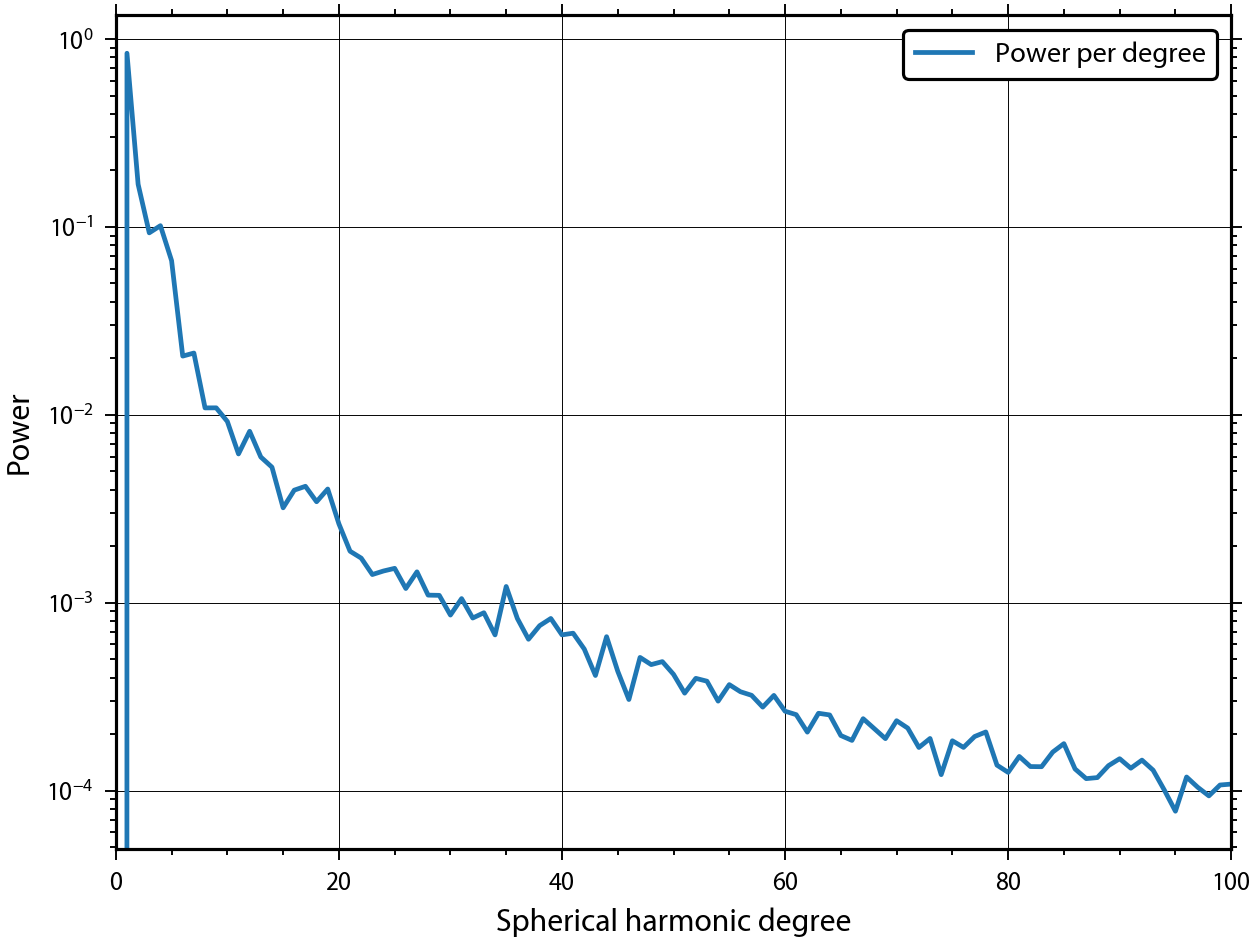

In [5]:
fig, ax = clm.plot_spectrum(show=False)    # show=False is used to avoid a warning when plotting in inline mode

By default, this method plots the power in units of power per spherical harmonic degree (`per_l`), but you can also choose from the average power per coefficient (`per_lm`) and the power per log bandwith (`per_dlogl`). You can visualize the power asociated with each spherical-harmonic coefficient using the `plot_spectrum2d()` method. In this example, we use the optional parameter `cmap_rlimits` to scale the colormap from 0.1 to 1.e-7 times the maximum value.

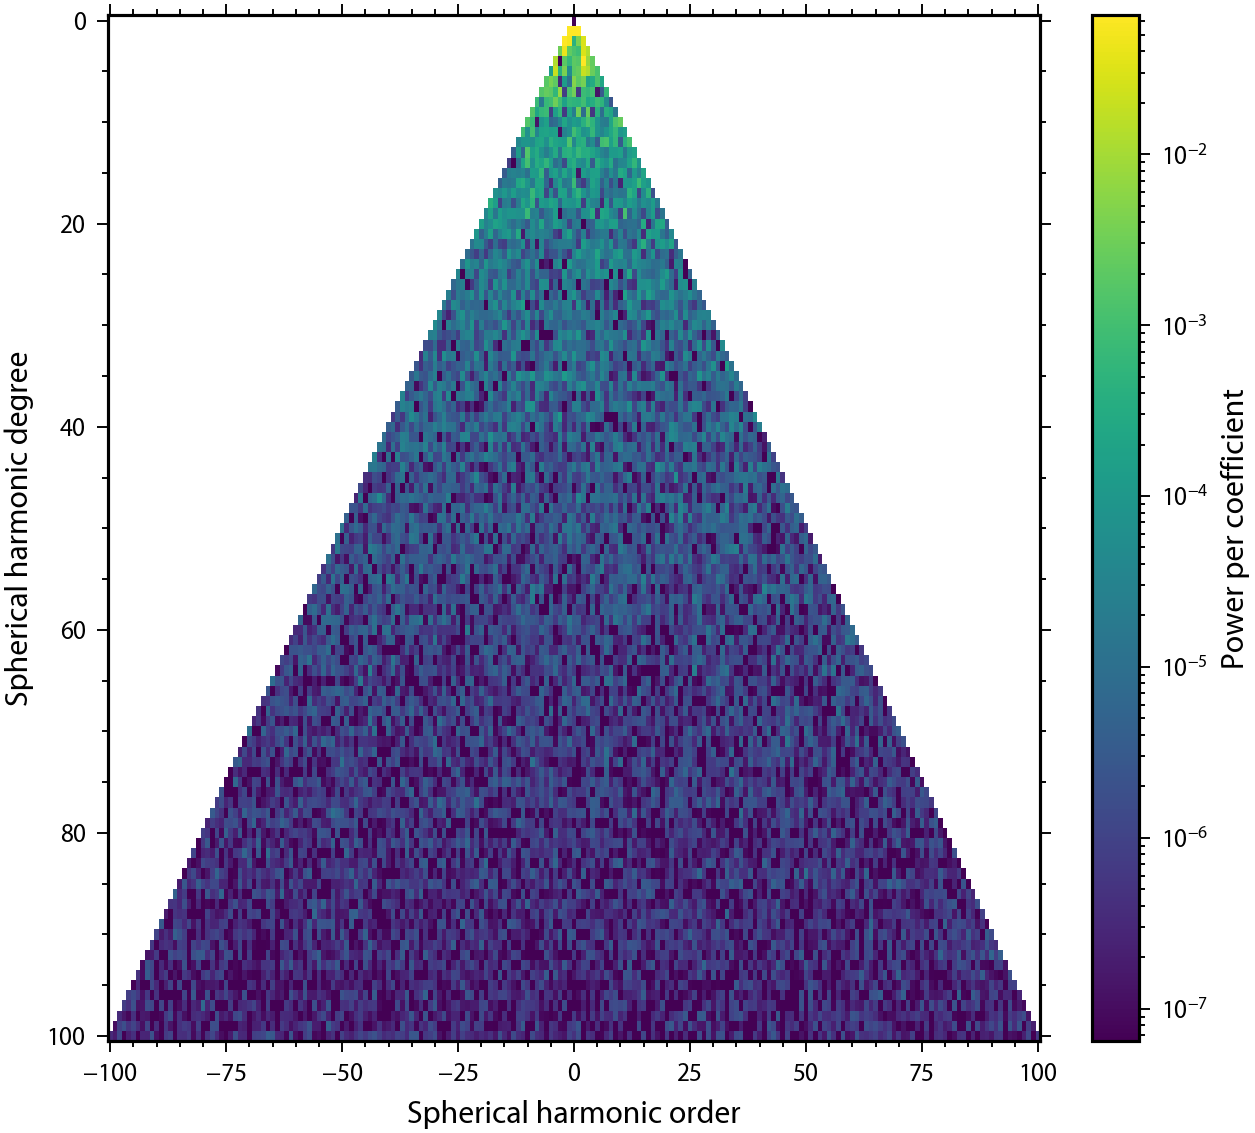

In [6]:
fig, ax = clm.plot_spectrum2d(cmap_rlimits=(1.e-7, 0.1),
                              show=False)

The spherical harmonic coefficients of a given `SHCoeffs` class instance can be converted easily to a different normalization using the `convert()` method. Here, we will convert the coeffients to the orthonormalized convention using the Condon-Shortley phase, which is common in many fields of physics and seismology. Also, let's just return the first 50 degrees of the function:

In [7]:
clm_ortho = clm.convert(normalization='ortho',
                        csphase=-1,
                        lmax=50)

If you ever forget how your data are normalized, you can use the built in `info()` method to remind you, or just print the variable:

In [8]:
print(clm_ortho)

kind = 'real'
normalization = 'ortho'
csphase = -1
lmax = 50
error_kind = None
header = None
header2 = None
name = None
units = None


We next calculate the power spectra of our two functions and plot them along with our input expectation spectrum:

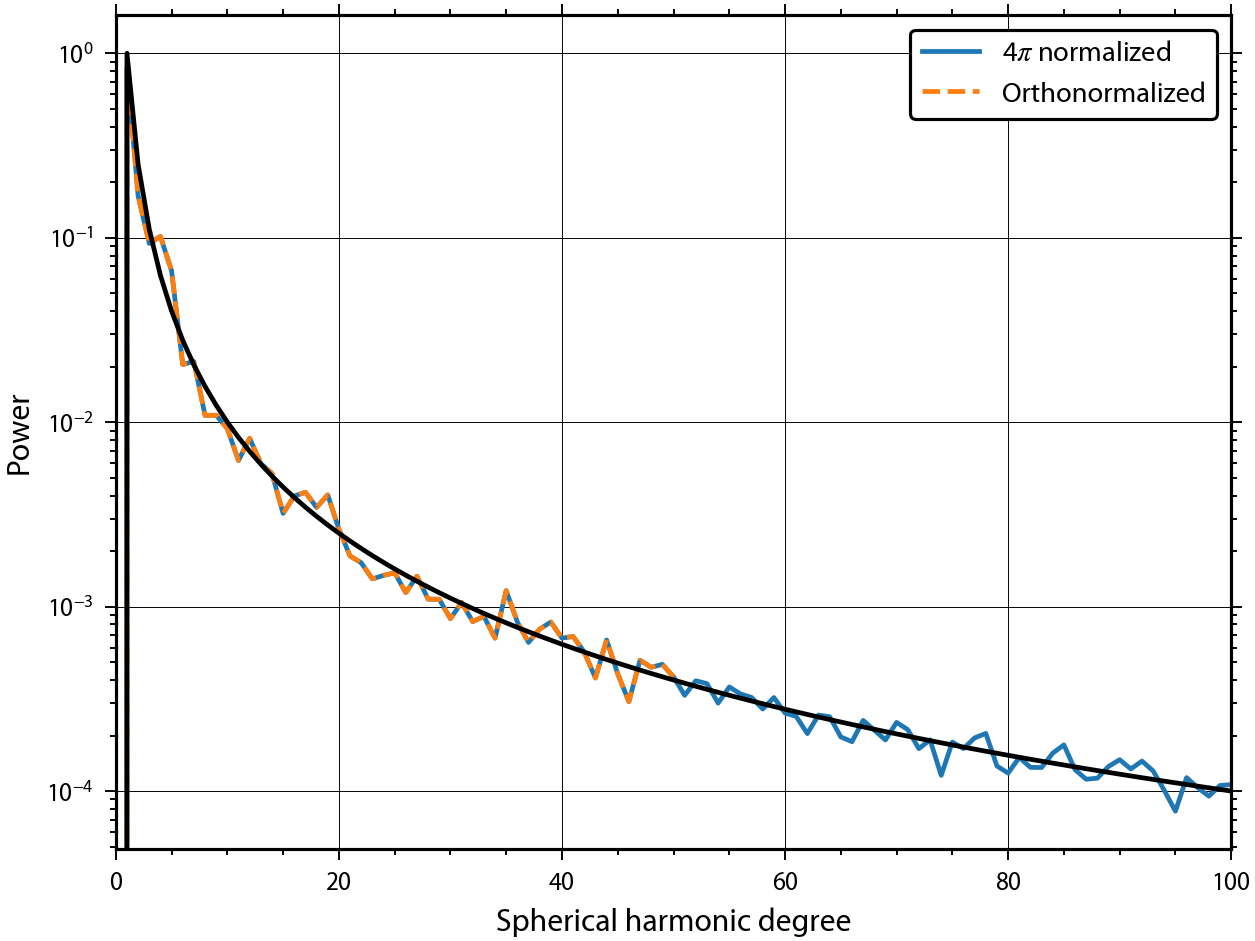

In [9]:
fig, ax = clm.plot_spectrum(legend='4$\pi$ normalized',
                            show=False)
clm_ortho.plot_spectrum(ax=ax,
                        linestyle='dashed',
                        legend='Orthonormalized')
ax.plot(clm.degrees(), power, '-k')
limits = ax.set_xlim(0, 100)

The method `degrees()` was here used to return a *numpy* list of the degrees from 0 up to the maximum value of the coefficients. As you can see, the power spectrum of the random realization follows closely the input expectation spectrum. Furthermore, the power spectra are seen to be independent of the chosen normalization.

Next, let's expand the data onto a grid and plot it. We first use the `expand()` method, which returns a new instance of the class `SHGrid`, and then plot the data using the built in method `plot()`.

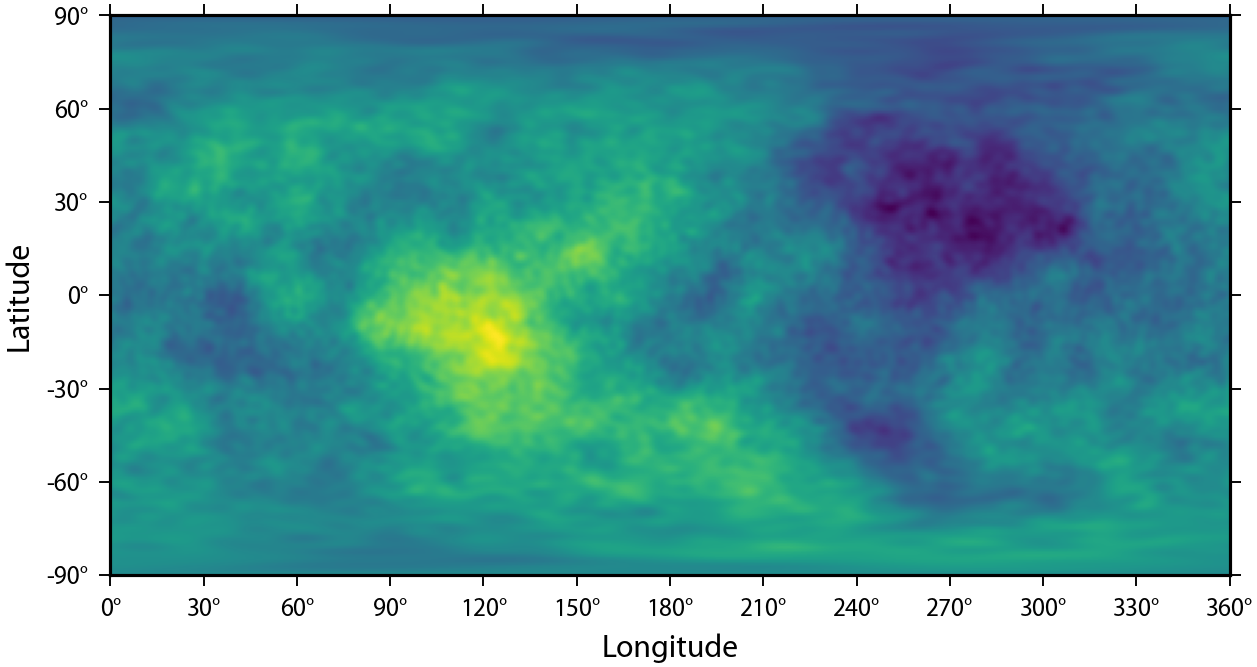

In [10]:
grid = clm.expand()
fig, ax = grid.plot(show=False)

*pyshtools* makes use of three different grid types. The default is to use `grid='DH2'`, which is an equally-spaced grid in degrees latitude and longitude that conforms to *Driscoll and Healy*'s (1994) sampling theorem. This grid is oversampled in longitude by a factor of two. If you would instead like a grid that has the same number of samples in longitude and latitude, use `grid='DH'` instead.

The third grid is constructed explicitly for use with Gauss-Legendre quadrature integration techniques. This grid contains about half as many latitude bands as an equivalent DH grid, but the latitudes are unequally sampled at the zeros of the Legendre polynomial of the maximum degree of the coefficients. The following commands show how to expand the spherical harmonic coefficents onto a GLQ grid, plot it, and output lists that contain the latitudes and longitudes (in degrees) for each row and column of the grid:

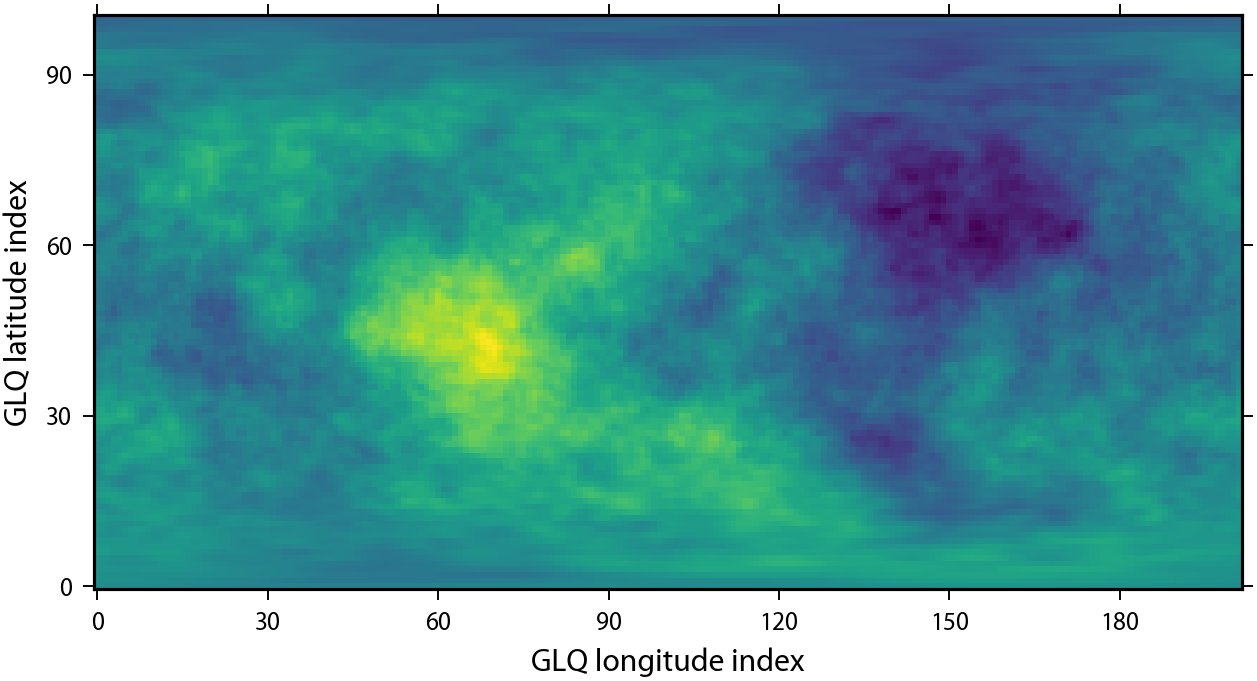

In [11]:
grid_glq = clm.expand(grid='GLQ')
grid_glq.plot(show=False)

lats = grid_glq.lats()
lons = grid_glq.lons()

If you ever forget how your grid was constructed, the `info()` method provides you with everything you need to know:

In [12]:
grid_glq.info()

kind = 'real'
grid = 'GLQ'
nlat = 101
nlon = 202
lmax = 100
units = None
extend = True


In [13]:
print(grid)

kind = 'real'
grid = 'DH'
n = 202
sampling = 2
nlat = 203
nlon = 405
lmax = 100
units = None
extend = True


Sometimes you need to set individual spherical harmonic coefficients to a specified value. For example, for planetary topography, the degree 2 and order 0 term can be atypically large as a result of the planet's rotation. Let's set this term equal to zero and replot it using an over-sampled DH grid. Though we will modify only a single coefficient here, you could also provide input arrays for `l`, `m`, and `value`. When using the `set_coeffs()` method, you set the cosine terms using positive values for the orders, and the sine terms using negative orders. We expand the modified coefficients on a grid, and then plot the data with a color bar to the right of the image:

kind = 'real'
grid = 'DH'
n = 202
sampling = 2
nlat = 203
nlon = 405
lmax = 100
units = None
extend = True


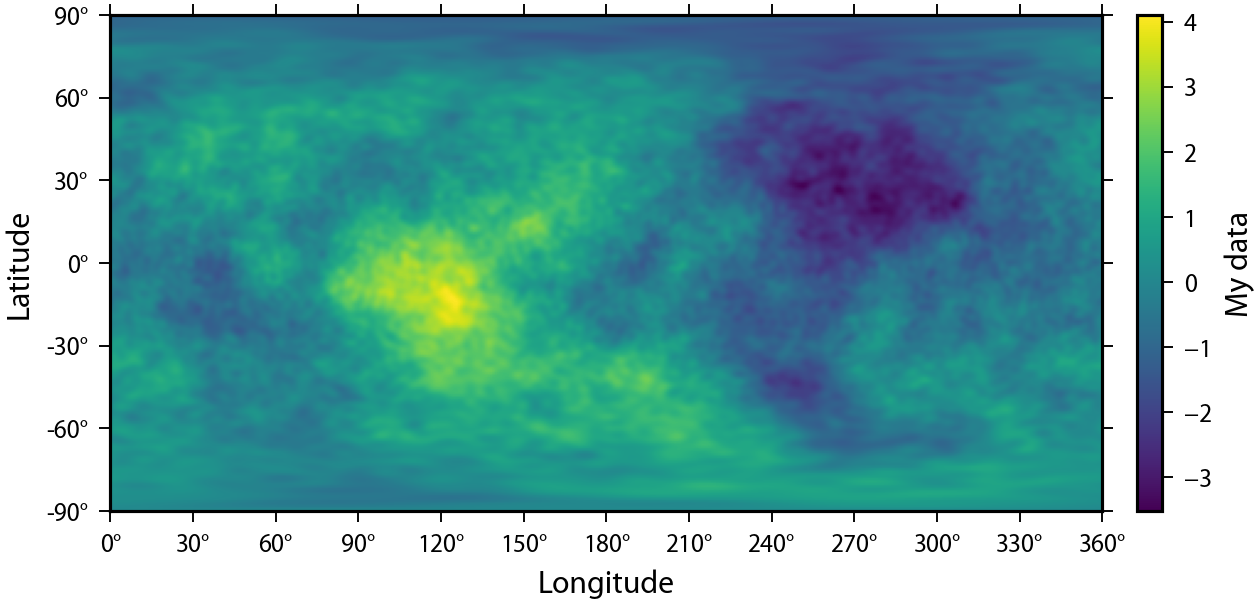

In [14]:
clm.set_coeffs(ls=2,
               ms=0,
               values=0.)
grid_dh2 = clm.expand()
fig, ax = grid_dh2.plot(colorbar='right',
                        cb_label='My data',
                        show=False)
grid_dh2.info()

If you want to save either the raw spherical harmonic coefficients to a file, or save the raw gridded data to a file, this can be done using the `to_file()` methods. If you want to extract the grid or coefficients as a *numpy* or *xarray* array, this can be done using the `to_array()` and `to_xarray()` methods. If you want to extract the gridded data as a netcdf file that can be used directly with the Generic Mapping Tools (GMT), use `to_netcdf()`. Here, we will just extract the first few degrees of the spherical harmonic coefficients and verify that the coefficient was indeed set to zero:

In [15]:
coeffs = clm.to_array(lmax=2)
print(coeffs, end='\n\n')
print('c20 = {:f}'.format(coeffs[0,2,0]))

[[[-0.          0.          0.        ]
  [-0.29989808 -0.32085104  0.        ]
  [ 0.          0.06300036  0.17195867]]

 [[ 0.          0.          0.        ]
  [ 0.          0.80448323  0.        ]
  [ 0.          0.22521439 -0.28984385]]]

c20 = 0.000000


Transforming gridded data into spherical harmonic coefficients is as easy as transforming spherical harmonic coefficients into a grid. To do this, we use the `expand()` method of the `SHGrid` class instance, which is analogous to using the `expand()` method of the `SHCoeffs` class instance to generate a grid from a set of coefficients):

In [16]:
clm_new = grid_dh2.expand()

If you need to evaluate the spherical harmonic coefficients at a specific set of points, this can also be accomplished using the `expand()` method. All that needs to be done is to provide a list or numpy array of the latitude and longitude coordinates:

In [17]:
clm.expand(lat=[90., 10., -45., -90.],
           lon=[0., 90., 275., 0.])

[array(-1.22816255), array(1.44422209), array(-0.07626479), array(0.09343263)]

It is also easy to rotate either the physical body or the underlying coordinate frame of the function expressed in spherical harmonics. This is accomplished using three Euler angles, `alpha`, `beta` and `gamma`. There are many different conventions for these angles, so please read the documentation before doing this blindly! Here, we will rotate the point at the north pole to 60 degrees north latitude and 180 degrees east longitude:

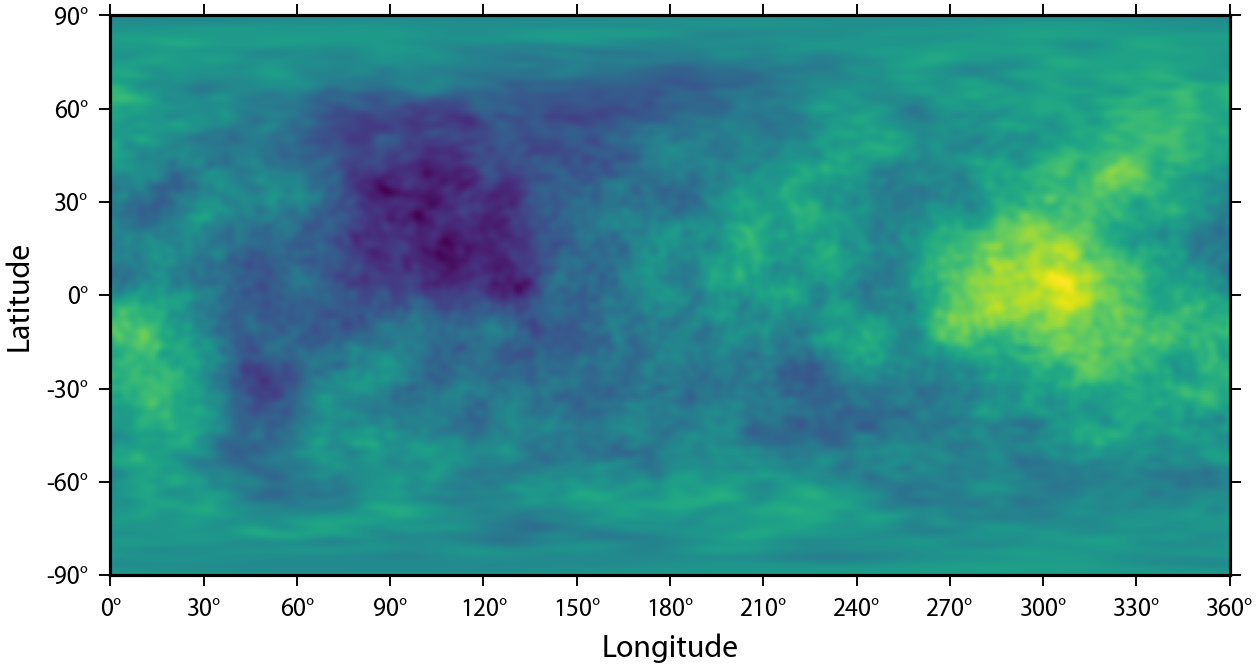

In [18]:
clat = 60.
clon = 180.

alpha = 0.
beta = -(90.-clat)
gamma = -clon

clm_rotated = clm.rotate(alpha, beta,gamma, degrees=True)
grid_rotated = clm_rotated.expand()
fig, ax = grid_rotated.plot(show=False)

By default, this routine expects the angles to be in degrees, which we specified redundantly by the provided optional parameter. If the angles were in radians, you would instead set this to `False`.

You can also perform simple arithmetic operations on `SHCoeffs` and `SHGrid` class instances. Let's create a second set of random coefficients whose power is 10 times less than our first set and expand this onto a grid.

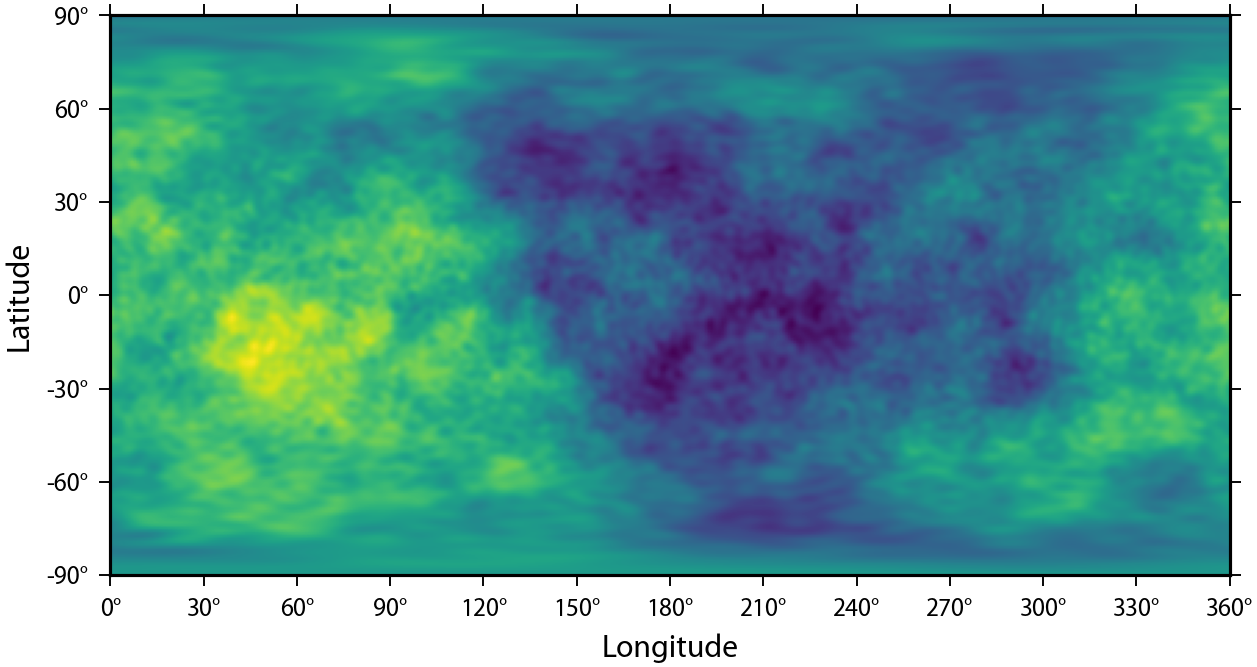

In [19]:
clm2 = pysh.SHCoeffs.from_random(power/10., seed=54321)
grid2 = clm2.expand()
fig, ax = grid2.plot(show=False)

We can add, subtract multiply, and divide sets of coefficients and grids. If you need to make an exact copy of either, you can use the `copy()` method.

In [20]:
grid3 = 2 * grid2
grid3 += 100
grid3 /= 2
grid4 = grid3.copy()

All of the operations in this introduction could have also been performed using the raw Python-wrapped Fortran 95 routines. In general, when using these routines, one needs to pay attention to the specific properties of the grids and normalizations of the coefficients. The `SHCoeffs` and `SHGrid` classes simpify the access to these routines given that all the metadata are stored directly in the class attributes. Nevertheless, in some cases the wrapped SHTOOLS routines might be preferable to use as they might be more computationally efficient, or perhaps use less memory. A few *pyshtools* routines are not accessible directly from the class interfaces, and in those cases, it is often necessary to input the raw coefficients and gridded data, which can be obtained from the methods `to_array()`.